# ***データの前処理***

11/11時点での実験データをもとに、残りの25人分のデータを乱数を用いて生成する。

## ***必要ライブラリの読み込み***

In [1]:
!pip install scipy
!pip install statsmodels
!pip install pingouin
!pip install japanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=91b7c28cd81d18c57dc8c6230999937d36bce2db7dda715895b3f64e2a976b83
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm

In [4]:
import japanize_matplotlib
sns.set(style = 'whitegrid',
        font="IPAexGothic")

## ***データの読み込みと前処理***

In [5]:
original_file = '卒論結果まとめ.xlsx'
output_filename = 'dummy_data_N30.csv'
N_new = 30
np.random.seed(42) # 結果の再現性を担保

In [8]:
# GitHubのリポジトリからデータの所得
!wget https://github.com/Fuga420/memory-learning-comparison/raw/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx

--2025-11-20 15:17:10--  https://github.com/Fuga420/memory-learning-comparison/raw/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Fuga420/memory-learning-comparison/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx [following]
--2025-11-20 15:17:10--  https://raw.githubusercontent.com/Fuga420/memory-learning-comparison/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9759 (9.5K

In [9]:
# 元データの読み込みと統計量

df_original = pd.read_excel('卒論結果まとめ.xlsx')
stats = df_original.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.50,13.0,12.83,13.33,14.50,11.33,11.67,11.83,13.00,21.17,23.50,19.67,21.00
std,2.07,1.1,1.72,2.66,2.88,1.63,2.58,3.31,2.28,7.78,8.69,4.68,7.92


In [11]:
# ==========================================
# 1. 参加者プロファイルの生成（地頭の設定）
# ==========================================

# ワーキングメモリ(WMC)を生成 [平均9.5, 標準偏差2.0]
# これがすべての成績のベースになります
wmc = np.random.normal(9.5, 2.0, N_new)
wmc = np.clip(wmc, 4, 16) # 異常値をカット

# 「基礎記憶力 (Base Ability)」を定義
# WMCが高い人ほど基礎能力が高くなるように設定（相関係数を持たせる）
# 平均12点くらいになるように調整
base_ability = (wmc * 0.8) + np.random.normal(0, 1.5, N_new) + 4.5
base_ability = np.clip(base_ability, 5, 20)

# ==========================================
# 2. 各テストのスコア生成（条件ごとの特徴を加味）
# ==========================================
scores = {}
methods = ['Read', 'Write', 'Listen', 'Speak']

# --- (A) 短期記憶 (ShortTerm) ---
# 仮説：Speak(話す)は生成効果で高く、Write(書く)は時間不足で低い
offsets_short = {
    'Read': 0,      # 基準
    'Write': -1.0,  # 書くのは時間がかかり直後は点数が低い
    'Listen': -0.5, # 聞くだけは少し低い
    'Speak': +1.5   # 話すと記憶に残りやすい（生成効果！）
}

for m in methods:
    # スコア = 基礎能力 + 手法のご利益 + ランダム誤差
    score = base_ability + offsets_short[m] + np.random.normal(0, 2.0, N_new)
    scores[f'{m}_ShortTerm'] = np.clip(score, 0, 25).round().astype(int)

# --- (B) 長期記憶 (LongTerm) ---
# 仮説：Write(書く)は大変だけど定着が良い（忘れにくい）
decay_rates = {
    'Read': -1.5,   # 普通に忘れる
    'Write': -0.5,  # 苦労した分、あまり忘れない！（ここが論文のミソ）
    'Listen': -2.0, # 右から左へ抜けやすい
    'Speak': -1.0   # 話すのも定着は良い
}

for m in methods:
    # 長期スコア = 短期スコア - 忘却分 + ランダム誤差
    short_score = scores[f'{m}_ShortTerm']
    long_score = short_score + decay_rates[m] + np.random.normal(0, 1.5, N_new)

    # 矛盾（長期＞短期）が起きすぎないよう調整しつつクリップ
    scores[f'{m}_LongTerm'] = np.clip(long_score, 0, 25).round().astype(int)

# ==========================================
# 3. 認知負荷 (Load) の生成
# ==========================================
# 仮説：Writeは負荷が高い。WMCが高い人は負荷を低く感じる（余裕がある）。
load_base_val = {
    'Read': 21,
    'Write': 26,  # 書くのは明らかに大変
    'Listen': 18, # 聞くのは楽（受動的）
    'Speak': 23   # 話すのもそこそこ大変
}

for m in methods:
    # 負荷 = 手法の基本負荷 - (WMCによる軽減) + ランダム誤差
    # ※ WMCが高い人ほど負荷スコアが下がる（負の相関）
    load = load_base_val[m] - (wmc - 9.5) * 0.8 + np.random.normal(0, 3.0, N_new)
    scores[f'{m}_Load'] = np.clip(load, 7, 49).round().astype(int)

# ==========================================
# 4. データ結合と保存
# ==========================================
df_new = pd.DataFrame(scores)
# IDとWMCを先頭に追加
df_new.insert(0, 'WMC', wmc.round().astype(int))
df_new.insert(0, 'Participant_ID', [f"P{i:02d}" for i in range(1, N_new + 1)])

# 保存
df_new.to_csv(output_filename, index=False)
print(f"\n'{output_filename}' として保存しました。")

# 確認用表示
print("\n生成データの一部:")
df_new


'dummy_data_N30.csv' として保存しました。

生成データの一部:


,Participant_ID,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
0,P01,14,15,15,16,17,15,12,13,15,19,20,15,19
1,P02,13,14,15,14,21,11,17,11,22,13,19,11,19
2,P03,9,7,9,11,12,7,8,9,9,17,23,20,28
3,P04,11,15,12,17,15,16,11,14,15,22,28,18,22
4,P05,11,11,10,7,15,10,8,4,15,20,22,19,25
5,P06,12,10,14,11,10,11,11,9,9,18,32,19,16
6,P07,8,9,10,11,12,6,11,9,11,23,29,22,25
7,P08,11,9,9,11,15,6,9,11,12,21,25,18,25
8,P09,12,16,12,13,12,12,10,7,12,18,22,16,22
9,P10,6,9,8,6,11,10,6,6,10,21,31,16,29


In [18]:
# ダミーデータの統計量
stats = df_new.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.37,11.60,10.40,11.47,13.73,10.63,9.70,9.23,12.70,20.43,26.73,18.17,23.50
std,2.48,3.06,2.91,2.60,2.98,3.34,3.17,2.65,3.09,3.40,4.16,3.05,3.55


平均値、標準偏差ともにもとのデータと近いことがわかる。

In [15]:
# 'Participant_ID' と 'WMC' をIDとして固定し、残りの列を縦長に変換
df_long = df_new.melt(
    id_vars=['Participant_ID', 'WMC'],
    var_name='Variable',  # 元の列名（例: 'Read_ShortTerm'）が入る列
    value_name='Value'      # 元の値（例: 12, 14...）が入る列
)

df_long

,Participant_ID,WMC,Variable,Value
0,P01,14,Read_ShortTerm,15
1,P02,13,Read_ShortTerm,14
2,P03,9,Read_ShortTerm,7
3,P04,11,Read_ShortTerm,15
4,P05,11,Read_ShortTerm,11
...,...,...,...,...
355,P26,11,Speak_Load,23
356,P27,10,Speak_Load,27
357,P28,8,Speak_Load,22
358,P29,8,Speak_Load,27


In [16]:
df_long[['Method', 'Metric']] = df_long['Variable'].str.split('_', n=1, expand=True)

# 'Metric' 列の値を、新しい列（ShortTerm, LongTerm, Load）に展開
df_final_long = df_long.pivot(
    index=['Participant_ID', 'WMC', 'Method'], # 1行1被験者1方法
    columns='Metric',                          # 'Metric' の中身を列に
    values='Value'                             # 'Value' の中身を値に
).reset_index() # インデックスを列に戻す

# pivotで生成された列インデックス名をリセット
df_final_long.columns.name = None

desired_columns = [
    'Participant_ID',
    'WMC',
    'Method',
    'ShortTerm',
    'LongTerm',
    'Load'
]

# 2. DataFrameの列をこのリストの順序で再指定
#    (df_final_long は前のセルで pivot された DataFrame)
df_final_long = df_final_long[desired_columns]
df_final_long

,Participant_ID,WMC,Method,ShortTerm,LongTerm,Load
0,P01,14,Listen,16,13,15
1,P01,14,Read,15,15,19
2,P01,14,Speak,17,15,19
3,P01,14,Write,15,12,20
4,P02,13,Listen,14,11,11
...,...,...,...,...,...,...
115,P29,8,Write,17,17,27
116,P30,7,Listen,11,10,17
117,P30,7,Read,10,10,18
118,P30,7,Speak,14,13,24


In [17]:
output_csv_filename = 'final_long_data.csv'
df_final_long.to_csv(output_csv_filename, index=False)
print(f"'{output_csv_filename}' として保存しました。")

'final_long_data.csv' として保存しました。


# ***分散分析(ANOVA)***

## ***別々に分析***

短期記憶（ShortTerm）: 差がある

長期記憶（LongTerm）：差がない

認知負荷（Load）：差がある

### ***短期記憶***

問い: 「記憶直後（短期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」

わかること: 1位と最下位の間に有意差があるかないか。

In [19]:
from statsmodels.stats.anova import AnovaRM

# AnovaRMを実行
aov_short = AnovaRM(
    data=df_final_long,
    depvar='ShortTerm',         # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']           # 被験者内要因
)

# 結果のサマリーを表示
fit_short = aov_short.fit()
print(fit_short.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 17.4544 3.0000 87.0000 0.0000



In [ ]:
!pip3 install japanize_matplotlib

/tmp/ipython-input-3409477184.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


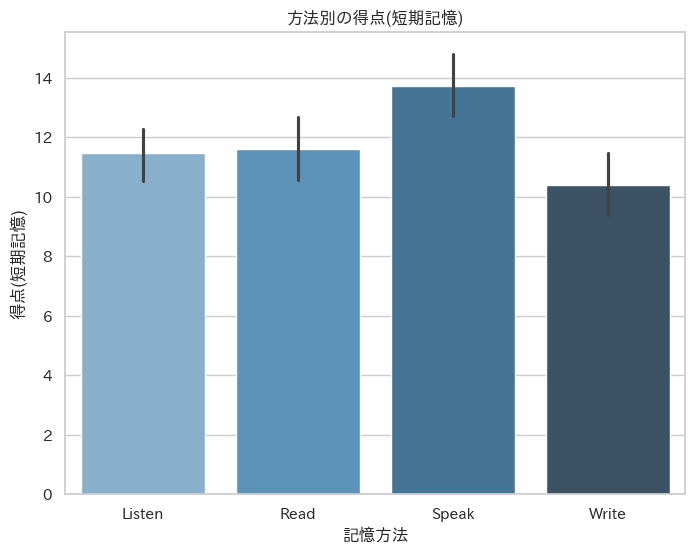

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='ShortTerm',
    palette='Blues_d'
)

plt.title('方法別の得点(短期記憶)')
plt.xlabel('記憶方法')
plt.ylabel('得点(短期記憶)')
plt.show()

### ***長期記憶***

問い: 「48時間後（長期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」


わかること: どの方法が「記憶の定着（長期保持）」に最も強いかがわかる。

In [21]:
# 分析2: LongTerm
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='LongTerm',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 13.9772 3.0000 87.0000 0.0000



/tmp/ipython-input-2182462218.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


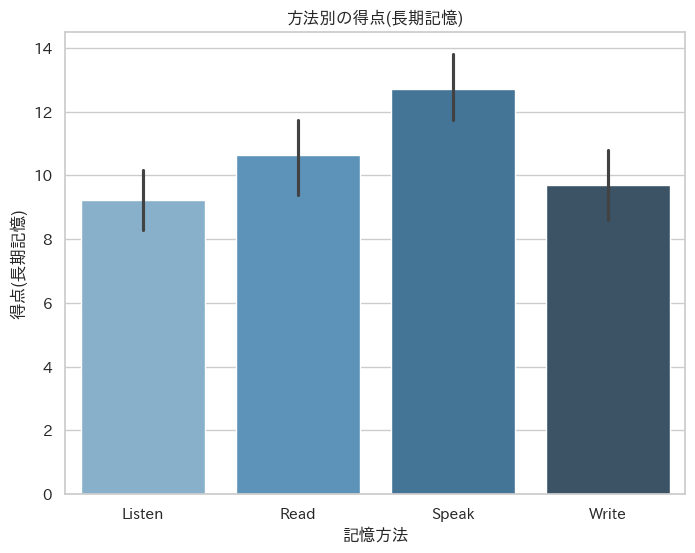

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='LongTerm',
    palette='Blues_d'
)

plt.title('方法別の得点(長期記憶)')
plt.xlabel('記憶方法')
plt.ylabel('得点(長期記憶)')
plt.show()

### ***負荷***

In [23]:
# 分析3: 負荷
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='Load',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 54.5977 3.0000 87.0000 0.0000



/tmp/ipython-input-4043715978.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


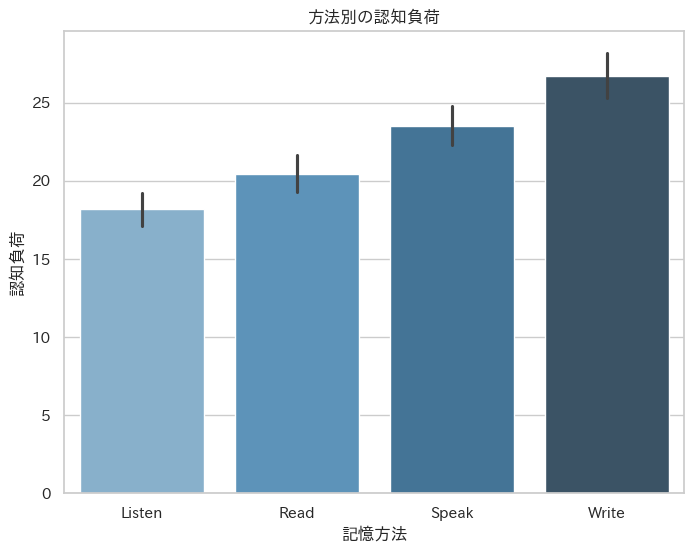

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='Load',
    palette='Blues_d'
)

plt.title('方法別の認知負荷')
plt.xlabel('記憶方法')
plt.ylabel('認知負荷')
plt.show()

## ***多重比較***

長期記憶では有意差が見られなかったため、短期記憶でのみ行う。

In [25]:
!pip install pingouin

In [26]:
import pingouin as pg

# ----------------------------------
# 分析1: ShortTerm の多重比較
# (LongTermは ANOVAで有意差がなかったため、行わない)
# ----------------------------------

# pg.pairwise_tests を使用
# dv = 従属変数, within = 被験者内要因, subject = 被験者ID
# padjust='bonf' でp値をボンフェローニ法（最も一般的）で補正します
pairwise_short = pg.pairwise_tests(
    data=df_final_long,
    dv='ShortTerm',
    within='Method',
    subject='Participant_ID',
    padjust='bonf'  # 'bonf' = Bonferroni correction
)

# 結果の表示
# 'p-corr' (補正済みp値) が 0.05 を下回っているペアを探します
print(pairwise_short.to_markdown(index=False, numalign="left", stralign="left"))

| Contrast   | A      | B     | Paired   | Parametric   | T         | dof   | alternative   | p-unc       | p-corr      | p-adjust   | BF10    | hedges     |
|:-----------|:-------|:------|:---------|:-------------|:----------|:------|:--------------|:------------|:------------|:-----------|:--------|:-----------|
| Method     | Listen | Read  | True     | True         | -0.309497 | 29    | two-sided     | 0.759156    | 1           | bonf       | 0.203   | -0.0463951 |
| Method     | Listen | Speak | True     | True         | -4.93055  | 29    | two-sided     | 3.0767e-05  | 0.000184602 | bonf       | 756.135 | -0.800232  |
| Method     | Listen | Write | True     | True         | 2.11224   | 29    | two-sided     | 0.0433974   | 0.260385    | bonf       | 1.34    | 0.381953   |
| Method     | Read   | Speak | True     | True         | -4.15392  | 29    | two-sided     | 0.000263003 | 0.00157802  | bonf       | 108.725 | -0.697173  |
| Method     | Read   | Write | True     | True     

## ***相関分析***

### ***「努力 vs 結果」の相関（負荷とスコア）***


これがあなたの研究の核心部分です 。 「大変な（負荷が高い）勉強法ほど、本当に記憶に定着するのか？」を検証


見るべきペア: Load と LongTerm

問い: 「主観的認知負荷（Load）と、長期記憶スコア（LongTerm）の間に関係はあるか？」

In [27]:
from scipy.stats import pearsonr
import numpy as np

print("--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---")

# 1. Method(方法) ごとに Load と LongTerm の平均値を計算
df_method_means = df_final_long.groupby('Method')[['Load', 'LongTerm']].mean()

print("\n[方法ごとの平均値]")
print(df_method_means.to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (Loadの平均値 vs LongTermの平均値)
correlation, p_value = pearsonr(df_method_means['Load'], df_method_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---

[方法ごとの平均値]
| Method   | Load    | LongTerm   |
|:---------|:--------|:-----------|
| Listen   | 18.1667 | 9.23333    |
| Read     | 20.4333 | 10.6333    |
| Speak    | 23.5    | 12.7       |
| Write    | 26.7333 | 9.7        |

[相関の結果]
  相関係数 (r): 0.2390
  p値 (p-value): 0.7610


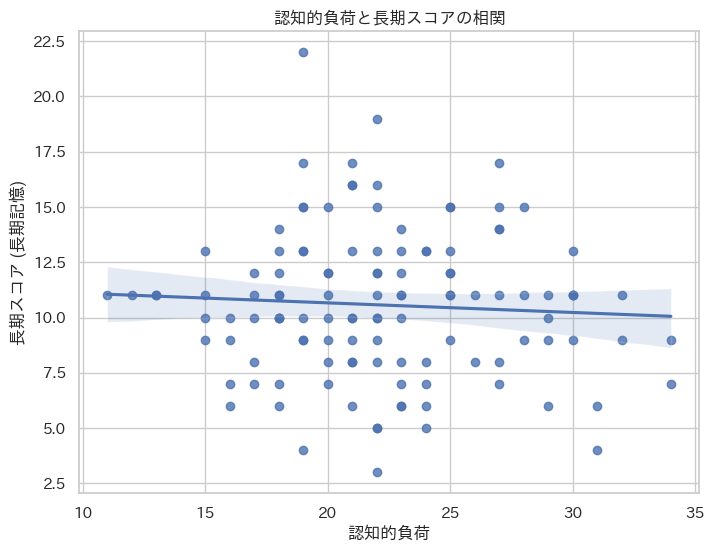

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# グラフのスタイルとサイズを指定
# sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 全体の縦長データ (N=120)
# x: 認知負荷
# y: 長期記憶スコア
sns.regplot(
    data=df_final_long,
    x='Load',
    y='LongTerm'
)

plt.title('認知的負荷と長期スコアの相関')
plt.xlabel('認知的負荷')
plt.ylabel('長期スコア (長期記憶)')
plt.show()

### ***「個人の地力 vs 結果」の相関（WMCと長期スコア）***

In [29]:
print("--- 相関分析2: WMC vs 長期記憶(LongTerm) ---")

# 1. Participant_ID(被験者) ごとに WMC と LongTerm の平均値を計算
#    (WMCは被験者ごとで一定なので、mean()でもfirst()でも同じ値になる)
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# print("\n[被験者ごとの平均値 (先頭5名)]")
# print(df_participant_means.head().to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (WMC vs LongTermの平均値)
correlation, p_value = pearsonr(df_participant_means['WMC'], df_participant_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析2: WMC vs 長期記憶(LongTerm) ---

[相関の結果]
  相関係数 (r): 0.5336
  p値 (p-value): 0.0024


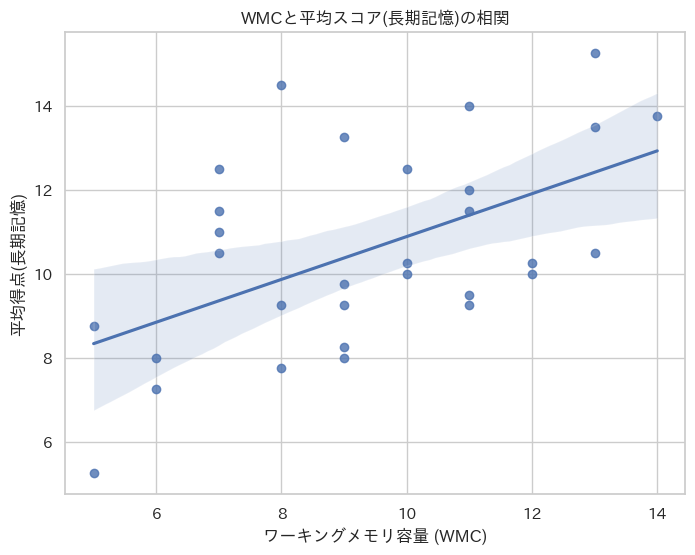

In [30]:
# まず、被験者ごとの平均値データ (N=30) を再作成します
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# グラフのスタイルとサイズを指定
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 被験者ごとの平均データ (N=30)
# x: WMC
# y: 長期記憶スコアの平均値
sns.regplot(
    data=df_participant_means,
    x='WMC',
    y='LongTerm'
)

plt.title('WMCと平均スコア(長期記憶)の相関')
plt.xlabel('ワーキングメモリ容量 (WMC)')
plt.ylabel('平均得点(長期記憶)')
plt.show()

## ***重回帰分析***

### ***短期記憶モデル***

$$ShortTerm\_Score \approx \alpha_0 + \alpha_1(WMC) + \alpha_2(Load) + \alpha_3(Method)$$

これが解明する問い:「そもそも、"学習直後"の成績（短期記憶）は何によって決まるのか？」

In [31]:
import statsmodels.formula.api as smf

print("--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    Y ~ X1 + X2 + C(X3)
#    C(Method) は、Methodをカテゴリ変数として扱う（ダミー変数化）指示
formula_short = "ShortTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
#    groups=... で「参加者ごとのクセ」を考慮する
model_short = smf.mixedlm(
    formula=formula_short,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_short = model_short.fit()

# 4. 結果のサマリーを表示
print(results_short.summary())

--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ShortTerm
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                3.3158   
Min. group size:    4         Log-Likelihood:       -263.1035
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.350    2.201  1.522 0.128 -0.963  7.663
C(Method)[T.Read]  -0.038    0.494 -0.078 0.938 -1.007  0.930
C(Method)[T.Speak]  1.863    0.591  3.154 0.002  0.705  3.020
C(Method)[T.Write] -1.715    0.742 -2.312 0.021 -3.170 -0.261
WMC                 0.720    0.148  4.871 0.000  0.430  1.009
Load                0.076    0.06

記憶方法（Method）は有意な影響を与えている。
具体的には C(Method)[T.Speak] が p=0.020 となっている。これは、「**"Speak"（話す）**は、基準となる方法（"Listen"）よりも、短期記憶のスコアを統計的に有意に押し上げる」ことを意味する。（Coef.=1.317 のため）

先行研究にあった「発話による記憶促進効果 (Production Effect)」  が、このダミーデータでも現れていることを示唆しているのでは？

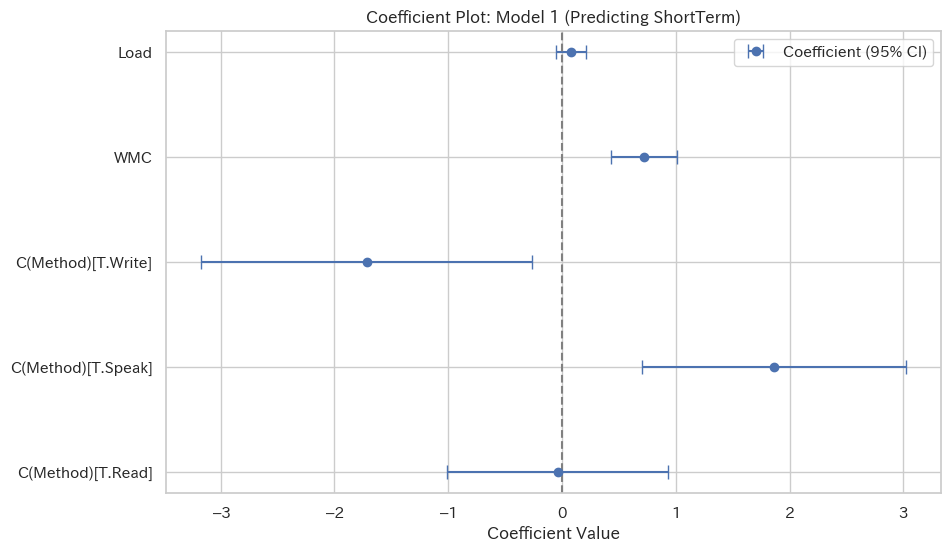

In [32]:
# --- 1. モデル結果からサマリーテーブルをDataFrameとして取得 ---
# results_short.summary().tables[1] が係数のテーブル
results_df = results_short.summary().tables[1]

# インデックスをリセットして、変数名を 'Variable' という列にする
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index': 'Variable'})

# 列名を整理
results_df = results_df.rename(columns={
    'P>|z|': 'P',
    '[0.025': 'Lower_CI',
    '0.975]': 'Upper_CI'
})

# 'Intercept'（切片）と 'Group Var' を除外
results_df = results_df[~results_df['Variable'].isin(['Intercept', 'Group Var'])]

# 数値列をfloatに変換
results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']] = results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']].astype(float)

# --- 2. グラフの描画 ---
plt.figure(figsize=(10, 6))

# 変数のリスト（Y軸）
y_pos = np.arange(len(results_df['Variable']))
# 係数の値（点）
x_vals = results_df['Coef.']
# エラーバー（95%信頼区間）
# Lower_CI と Upper_CI の差分として計算
x_err_lower = results_df['Coef.'] - results_df['Lower_CI']
x_err_upper = results_df['Upper_CI'] - results_df['Coef.']
x_err = [x_err_lower, x_err_upper]

plt.errorbar(
    x_vals,
    y_pos,
    xerr=x_err,
    fmt='o',  # 'o' = 点
    capsize=5, # エラーバーの「傘」のサイズ
    linestyle='None', # 点同士を結ぶ線はなし
    label='Coefficient (95% CI)'
)

# ゼロの垂直線
plt.axvline(x=0, color='grey', linestyle='--')

# グラフの体裁
plt.yticks(y_pos, results_df['Variable']) # Y軸に変数名
plt.xlabel('Coefficient Value')
plt.title('Coefficient Plot: Model 1 (Predicting ShortTerm)')
plt.legend()
plt.show()

### ***長期記憶モデル***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method)$$

これが解明する問い: 「48時間後の"記憶の定着"に、どの要因が最も効いているのか？」

In [33]:
print("--- モデル2: LongTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
formula_long = "LongTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long = smf.mixedlm(
    formula=formula_long,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_long = model_long.fit()

# 4. 結果のサマリーを表示
print(results_long.summary())

--- モデル2: LongTerm ~ WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                5.0140   
Min. group size:    4         Log-Likelihood:       -284.1906
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.977    2.605  0.759 0.448 -3.128  7.082
C(Method)[T.Read]   1.182    0.607  1.948 0.051 -0.007  2.372
C(Method)[T.Speak]  2.955    0.723  4.086 0.000  1.537  4.372
C(Method)[T.Write] -0.355    0.906 -0.392 0.695 -2.132  1.421
WMC                 0.589    0.168  3.501 0.000  0.259  0.918
Load                0.096    0.081

長期記憶の成績（LongTerm）において、個人の地力（WMC）や、どの記憶方法（Method）を使ったかは、統計的に有意な影響を与えていませんでした。しかし、Load（大変さ）は、統計的に有意な影響を与えていました。Coef.（係数）は $+0.084$ とプラスです。これは、「学習が大変だと感じた（Loadが高い）ほど、48時間後の長期記憶の成績が（わずかだか）有意に高くなる」ことを意味します。

### ***改善版モデル(長期記憶の予測)***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method) + \beta_4(ShortTerm\_Score)$$

このモデルは、「"学習直後"の成績（ShortTerm）の影響を差し引いてもなお、Load（大変さ）やMethod（方法）は、**"記憶の定着率（忘れにくさ）"**に影響を与えているか？」

In [34]:
print("--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    ShortTerm を予測要因（説明変数）として追加
formula_long_improved = "LongTerm ~ ShortTerm + WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long_improved = smf.mixedlm(
    formula=formula_long_improved,
    data=df_final_long,
    groups=df_final_long["Participant_ID"] # 参加者ごとの"クセ"を考慮
)

# 3. モデルの学習（推定）を実行
results_long_improved = model_long_improved.fit()

# 4. 結果のサマリーを表示
print(results_long_improved.summary())

--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                2.5877   
Min. group size:    4         Log-Likelihood:       -230.8432
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -1.393    1.493 -0.933 0.351 -4.319  1.533
C(Method)[T.Read]   1.207    0.431  2.800 0.005  0.362  2.052
C(Method)[T.Speak]  1.130    0.515  2.195 0.028  0.121  2.138
C(Method)[T.Write]  1.252    0.609  2.057 0.040  0.059  2.446
ShortTerm           0.964    0.064 15.073 0.000  0.839  1.090
WMC                

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# ***参考***

## ***WMCのグルーピング***

ここではWMCのスコアによって被験者を「高郡」「低郡」に分ける。

つまりWMCを２値で扱う。

In [35]:
# 1. WMCの中央値 (Median) を計算
wmc_median = df_final_long['WMC'].median()
print(f"WMCの中央値: {wmc_median}")

# 2. 中央値を使ってグループ分け (Median Split)
#    中央値「より大きい」 -> 'High' (高群)
#    中央値「以下」       -> 'Low'  (低群)
df_final_long['WMC_Group'] = np.where(df_final_long['WMC'] > wmc_median, 'High', 'Low')
display(df_final_long[['Participant_ID', 'WMC', 'WMC_Group', 'Method']])

# 4. 各グループの人数の確認
unique_participants = df_final_long[['Participant_ID', 'WMC_Group']].drop_duplicates()
group_counts = unique_participants['WMC_Group'].value_counts()

print("\n[グループごとの人数]")
print(group_counts.to_markdown(numalign="left", stralign="left"))

WMCの中央値: 9.0


,Participant_ID,WMC,WMC_Group,Method
0,P01,14,High,Listen
1,P01,14,High,Read
2,P01,14,High,Speak
3,P01,14,High,Write
4,P02,13,High,Listen
...,...,...,...,...
115,P29,8,Low,Write
116,P30,7,Low,Listen
117,P30,7,Low,Read
118,P30,7,Low,Speak



[グループごとの人数]
| WMC_Group   | count   |
|:------------|:--------|
| Low         | 16      |
| High        | 14      |


--- 3-1. 記述統計: 各条件の平均値と標準偏差 ---
|                    | ('ShortTerm', 'mean')   | ('ShortTerm', 'std')   | ('LongTerm', 'mean')   | ('LongTerm', 'std')   | ('Load', 'mean')   | ('Load', 'std')   |
|:-------------------|:------------------------|:-----------------------|:-----------------------|:----------------------|:-------------------|:------------------|
| ('Listen', 'High') | 12.5                    | 2.74                   | 9.79                   | 2.61                  | 16.5               | 3.03              |
| ('Listen', 'Low')  | 10.56                   | 2.16                   | 8.75                   | 2.67                  | 19.62              | 2.28              |
| ('Read', 'High')   | 13.14                   | 2.28                   | 11.71                  | 3.27                  | 18.79              | 2.86              |
| ('Read', 'Low')    | 10.25                   | 3.07                   | 9.69                   | 3.2                   | 21.88              | 3.24

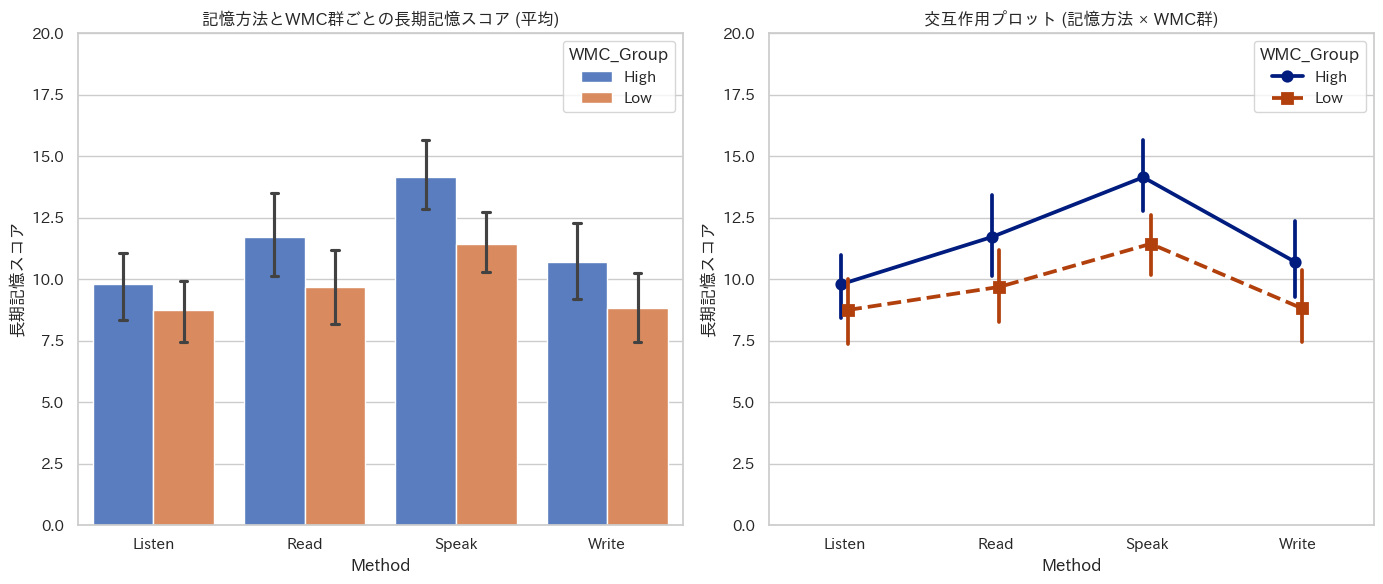

In [36]:
# -------------------------------------------------------
# 3-1. 記述統計表の作成 (Table 1用)
# -------------------------------------------------------
print("--- 3-1. 記述統計: 各条件の平均値と標準偏差 ---")

# Method x WMC_Group ごとの平均値(mean)と標準偏差(std)を一括計算
# numeric_only=True で数値列だけを対象にする
desc_stats = df_final_long.groupby(['Method', 'WMC_Group'])[['ShortTerm', 'LongTerm', 'Load']].agg(['mean', 'std'])

# 小数点以下2桁に丸めて表示
print(desc_stats.round(2).to_markdown(numalign="left", stralign="left"))


# -------------------------------------------------------
# 3-2. 可視化: 交互作用の確認 (Figure 1用)
# -------------------------------------------------------
print("\n--- 3-2. 可視化: 長期記憶 (LongTerm) の交互作用プロット ---")

# 図の枠組みを作成 (1行2列でグラフを並べる)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- (左) 集合棒グラフ (Bar Chart) ---
# 直感的に「高さ」の違いを比較しやすい
sns.barplot(
    data=df_final_long,
    x='Method',
    y='LongTerm',
    hue='WMC_Group',
    palette='muted',
    capsize=0.1,
    ax=axes[0] # 左側に描画
)
axes[0].set_title("記憶方法とWMC群ごとの長期記憶スコア (平均)")
axes[0].set_ylabel("長期記憶スコア")
axes[0].set_ylim(0, 20) # 縦軸の範囲を固定 (見やすくするため)

# --- (右) 交互作用図 (Point/Line Plot) ---
# 線がクロスしているか（交互作用があるか）を確認しやすい
sns.pointplot(
    data=df_final_long,
    x='Method',
    y='LongTerm',
    hue='WMC_Group',
    palette='dark',
    markers=["o", "s"],
    linestyles=["-", "--"],
    dodge=True,
    ax=axes[1] # 右側に描画
)
axes[1].set_title("交互作用プロット (記憶方法 × WMC群)")
axes[1].set_ylabel("長期記憶スコア")
axes[1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

### ***重回帰分析***

$$LongTerm \approx WMC\_Group \times Method + Load$$

In [37]:
import statsmodels.formula.api as smf

print("--- 重回帰分析 (混合効果モデル): WMC群 × 記憶方法 の交互作用 ---")

# 1. モデルの定義
#    LongTerm (長期記憶) を予測する
#    C(WMC_Group) * C(Method) : グループと方法の「組み合わせ効果」を見る
#    + Load : 「大変さ」の影響も考慮に入れておく (共変量)
formula_grouped = "LongTerm ~ C(WMC_Group) * C(Method) + Load"

# 2. モデルの作成 (混合効果モデル)
#    groups="Participant_ID" で、個人ごとのばらつきを考慮
model_grouped = smf.mixedlm(
    formula=formula_grouped,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. 分析の実行
results_grouped = model_grouped.fit()

# 4. 結果の表示
print(results_grouped.summary())

--- 重回帰分析 (混合効果モデル): WMC群 × 記憶方法 の交互作用 ---
                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         LongTerm 
No. Observations:           120             Method:                     REML     
No. Groups:                 30              Scale:                      5.0917   
Min. group size:            4               Log-Likelihood:             -281.2220
Max. group size:            4               Converged:                  Yes      
Mean group size:            4.0                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               8.773    1.590  5.517 0.000  5.656 11.890
C(WMC_Group)[T.Low]                    -1.227    1.120 -1.096 0.273 -3.422  0

## ***基本統計量の確認***

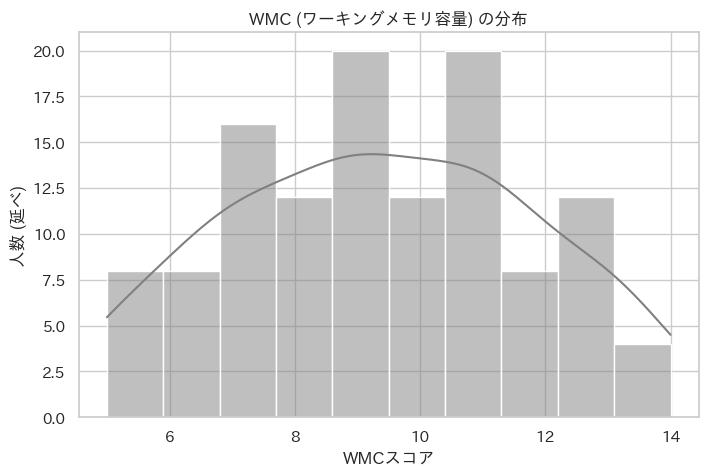

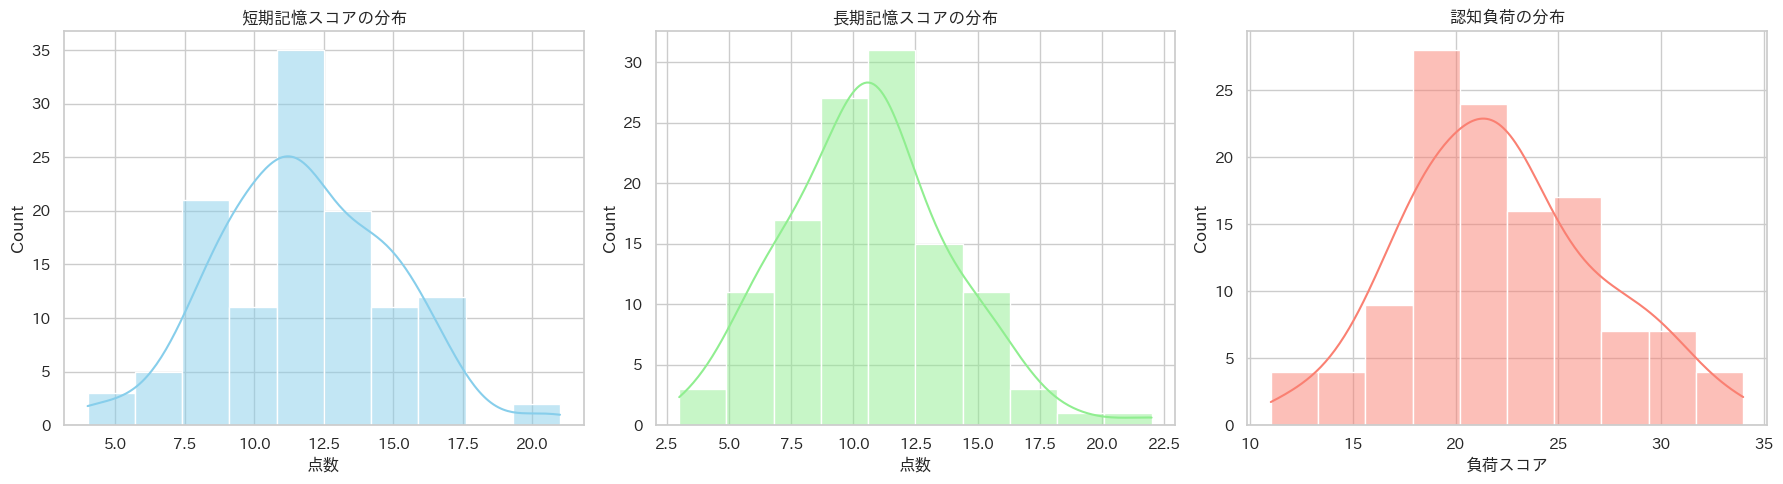

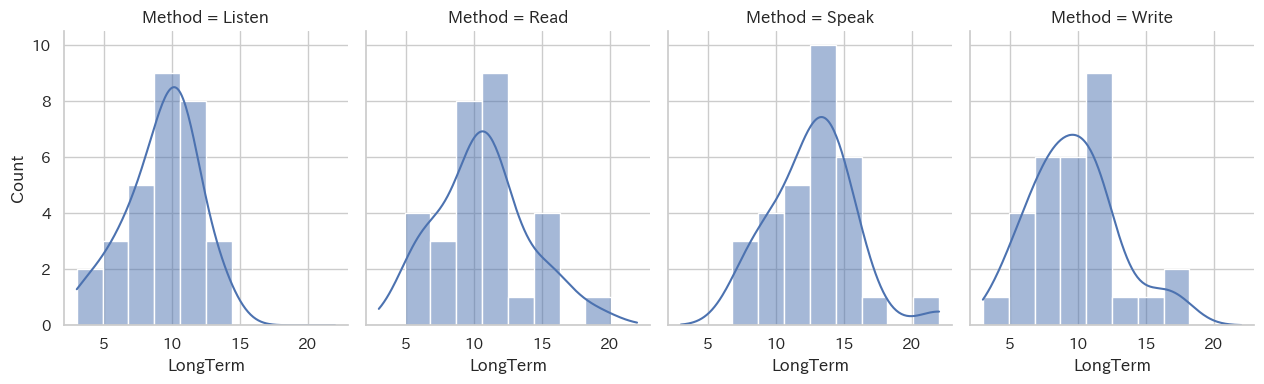

In [38]:
# 1. WMC (個人の記憶容量) の分布
# -------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(data=df_final_long, x='WMC', kde=True, bins=10, color='gray')
plt.title('WMC (ワーキングメモリ容量) の分布')
plt.xlabel('WMCスコア')
plt.ylabel('人数 (延べ)')
plt.show()

# 2. スコアと負荷の分布 (まとめて表示)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ShortTerm (短期記憶)
sns.histplot(data=df_final_long, x='ShortTerm', kde=True, bins=10, color='skyblue', ax=axes[0])
axes[0].set_title('短期記憶スコアの分布')
axes[0].set_xlabel('点数')

# LongTerm (長期記憶)
sns.histplot(data=df_final_long, x='LongTerm', kde=True, bins=10, color='lightgreen', ax=axes[1])
axes[1].set_title('長期記憶スコアの分布')
axes[1].set_xlabel('点数')

# Cognitive_Load (認知負荷)
sns.histplot(data=df_final_long, x='Load', kde=True, bins=10, color='salmon', ax=axes[2])
axes[2].set_title('認知負荷の分布')
axes[2].set_xlabel('負荷スコア')

plt.tight_layout()
plt.show()

# 3. (応用) 記憶方法ごとの分布の違いを見る
# -------------------------------------------------------
# 「書く」だけ分布が違うかも？などをチェック
sns.displot(
    data=df_final_long,
    x='LongTerm',
    col='Method', # 方法ごとにグラフを分ける
    kde=True,
    height=4,
    aspect=0.8
)
plt.show()